In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda
import time

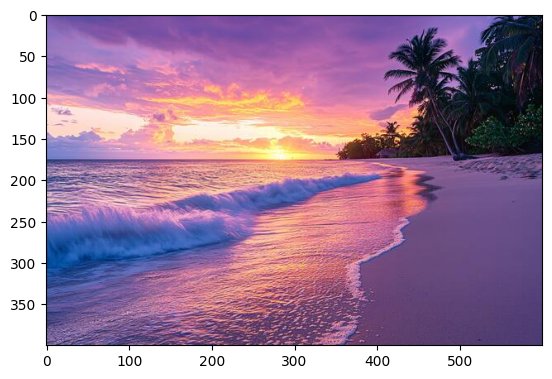

In [2]:
img = plt.imread('./image.jpg')
plt.imshow(img)
plt.show()

In [3]:
height = img.shape[0]
width = img.shape[1]
depth = img.shape[2]
pixel_count = height * width

img_1d_array = img.reshape(pixel_count, depth)

Elapsed time = 0.7702395915985107s


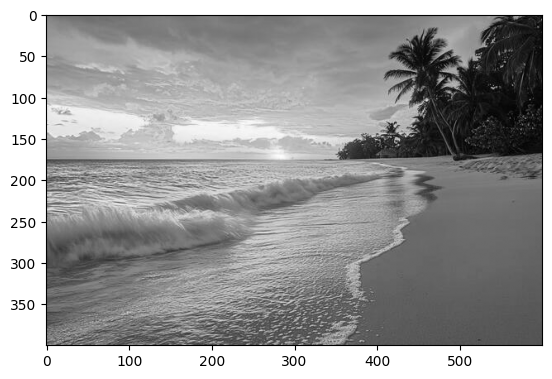

In [4]:
def cpu_color2rgb(img_array):
    gray_img_1d = np.zeros(shape=(pixel_count), dtype=np.uint8)
    for i in range(pixel_count):
        temp = (1/3) * np.sum(img_array[i])
        gray_img_1d[i] = temp
    return gray_img_1d

start = time.time()
gray_img_1d = cpu_color2rgb(img_1d_array)
gray_img_cpu = gray_img_1d.reshape(height, width)
end = time.time()
print("Elapsed time = {}s".format((end - start)))
plt.imshow(gray_img_cpu, cmap="gray")
plt.show()

In [5]:
@cuda.jit
def gpu_color2rgb(img_array, gray_img_ary):
    pos = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if pos < img_array.size:  # Check array boundaries
        gray_img_ary[pos] = (1/3) * (img_array[pos][0] + img_array[pos][1] + img_array[pos][2])

Elapsed GPU time = 0.3248887062072754s


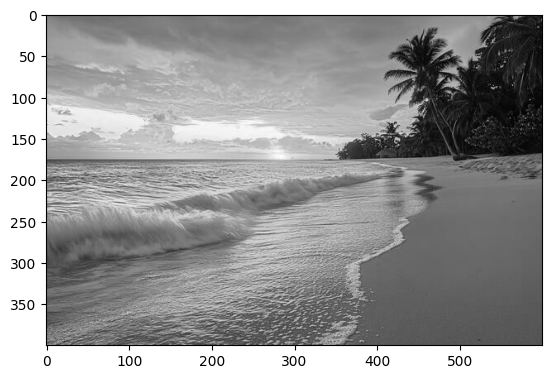

In [6]:
img_1d_ary = cuda.to_device(img_1d_array)
gray_img_ary = cuda.device_array(shape=(pixel_count))

threadsperblock = 32
blockspergrid = (pixel_count + (threadsperblock - 1)) // threadsperblock
start = time.time()
gpu_color2rgb[blockspergrid, threadsperblock](img_1d_ary, gray_img_ary)
end = time.time()
print("Elapsed GPU time = {}s".format((end - start)))
gray_img_array = gray_img_ary.copy_to_host()
gray_img =  gray_img_array.reshape(height, width)
plt.imshow(gray_img, cmap="gray")
plt.show()

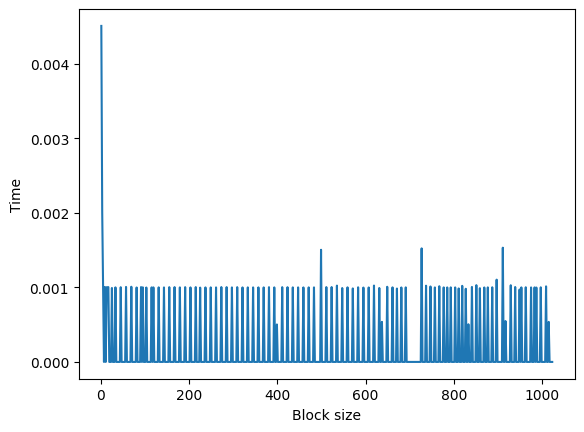

In [23]:
def different_block_size(threadsperblock_value_list):
    values = []
    for threadsperblock in threadsperblock_value_list:
        blockspergrid = (pixel_count + (threadsperblock - 1)) // threadsperblock
        start = time.time()
        gpu_color2rgb[blockspergrid, threadsperblock](img_1d_ary, gray_img_ary)
        cuda.synchronize()
        end = time.time()
        duration = end - start
        values.append((threadsperblock, duration))
    return values

threadsperblock_value_list = np.arange(1, 1024, 2).tolist()
values = different_block_size(threadsperblock_value_list)
threadsperblock_val = [value[0] for value in values]
time_val = [value[1] for value in values]
plt.plot(threadsperblock_val, time_val)
plt.xlabel("Block size")
plt.ylabel("Time")
plt.show()